In [2]:
# Import useful modules
import glob
import os
import os.path as op
import sys
import csv
import numpy as np
import pandas as pd
import time

import nibabel as nib
from nilearn.masking import compute_epi_mask
from nilearn.masking import apply_mask
from nilearn.input_data import MultiNiftiMasker

from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression
from nilearn.image import math_img, mean_img, threshold_img
from nilearn.plotting import plot_glass_brain
from nilearn.plotting import plot_anat
from nilearn.plotting import view_img
from nilearn.image import coord_transform


from nistats import datasets
from nilearn import plotting

import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import io as sio

%matplotlib inline

/home/tb258044/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/tb258044/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/tb258044/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/tb258044/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
#%%
###############################################################################
# Create a write directory to work
# it will be a 'results' subdirectory of the current directory.
from os import mkdir, path, getcwd
write_dir = path.join(getcwd(), 'results')
if not path.exists(write_dir):
    mkdir(write_dir)

In [4]:
## Import functional datasets
data_sess1 = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/preprocEPI/fMRI/wuaepi_sess1_sb120316_20140909_08.nii'
data_sess2 = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/preprocEPI/fMRI/wuaepi_sess2_sb120316_20140909_10.nii'
data_sess3 = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/preprocEPI/fMRI/wuaepi_sess3_sb120316_20140909_12.nii'
data_sess4 = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/preprocEPI/fMRI/wuaepi_sess4_sb120316_20140909_14.nii'
fmri_img = [data_sess1, data_sess2, data_sess3, data_sess4]

/home/tb258044/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/tb258044/.local/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


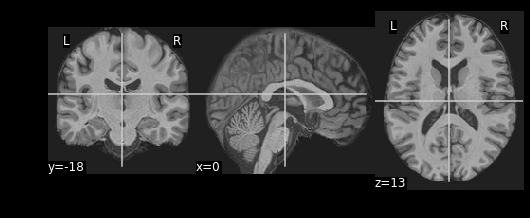

In [5]:
# Anatomical view of the brain for one subject
anat_brain = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/preprocAnat/wBrain.nii'
plotting.plot_anat(anat_brain)

In [6]:
# Create a mean image for plotting purpose
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_img[0])  # compute the mean image that will serve as a background image for the maps

In [7]:
## Load data of the design matrix and put it into a pandas DataFrame

# Loading data
k_subject = 1
filepath = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj'+str(k_subject).zfill(2)+'/first_level_estimates/Model01_QualityCheck/SPM.mat'
SPM = sio.loadmat(filepath)['SPM']
#type(SPM)
a = SPM[0][0]
#print(a.dtype)
xX_X = a['xX']['X']
design_mat_file = xX_X[0][0]
#print(design_mat_file.shape)

# Put the relevant data into a Pandas DataFrame
design_matrix = pd.DataFrame(design_mat_file)

n_regressors = design_matrix.shape[1]

# Split into 4 sessions
sess1 = design_matrix.loc[design_matrix[n_regressors-4]==1]
sess2 = design_matrix.loc[design_matrix[n_regressors-3]==1]
sess3 = design_matrix.loc[design_matrix[n_regressors-2]==1]
sess4 = design_matrix.loc[design_matrix[n_regressors-1]==1]
design_matrices = [sess1, sess2, sess3, sess4]
#print(design_matrices)

Text(0.5, 1.0, 'Session 1')

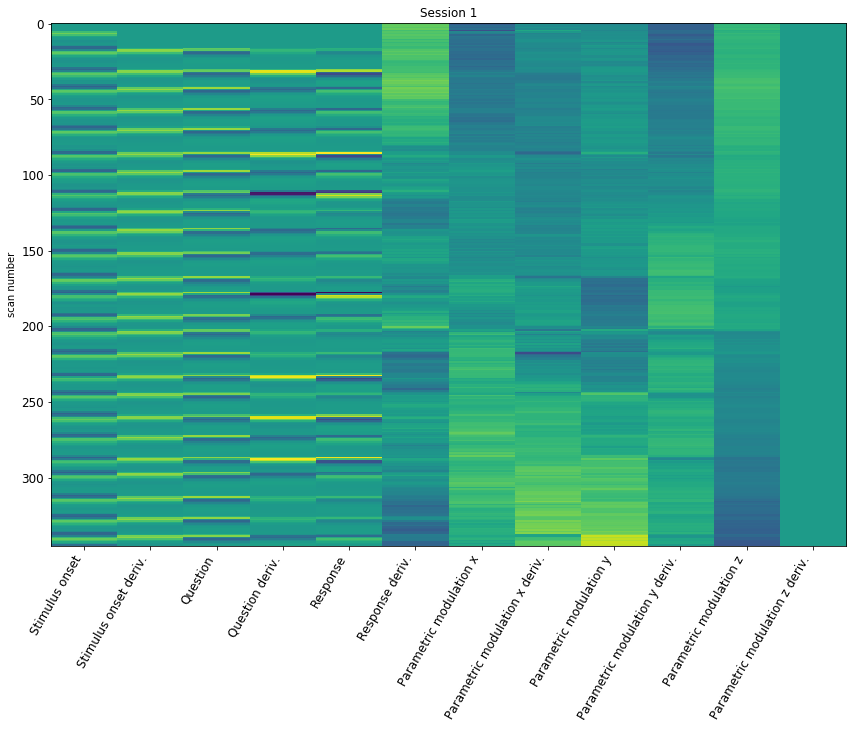

In [94]:
matrix1 = sess1.iloc[:,1:13]
fig, (ax1) = plt.subplots(figsize=[12,8])
plot_design_matrix(matrix1, ax = ax1)
plt.xticks(np.arange(12), ('Stimulus onset', 'Stimulus onset deriv.', 
                           'Question', 'Question deriv.', 
                           'Response', 'Response deriv.', 
                           'Parametric modulation x', 'Parametric modulation x deriv.', 
                           'Parametric modulation y', 'Parametric modulation y deriv.', 
                           'Parametric modulation z', 'Parametric modulation z deriv.'))
plt.title('Session 1')

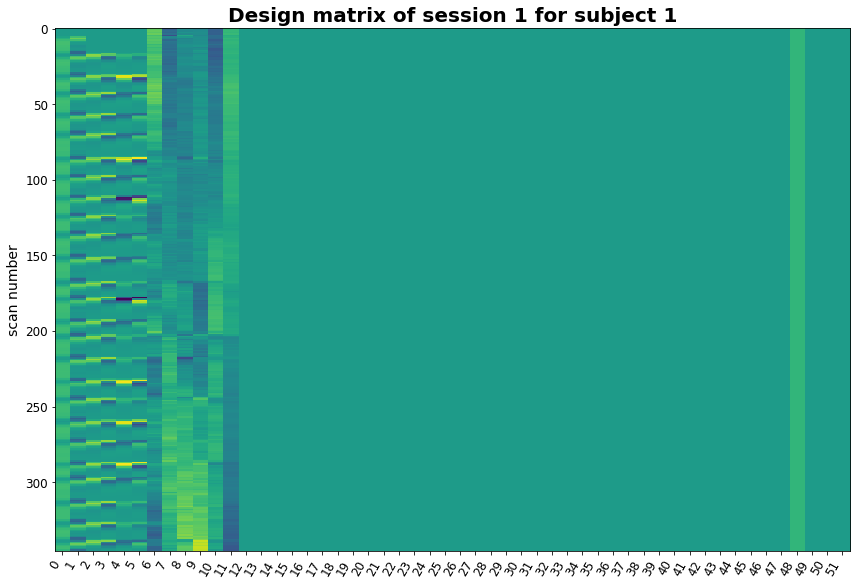

In [11]:
# Plot the design matrix 
from nistats.reporting import plot_design_matrix
fig, (ax1) = plt.subplots(figsize=(12, 8))
plot_design_matrix(sess1, ax = ax1)
ax1.set_title(f'Design matrix of session 1 for subject {k_subject}', fontsize=20, fontweight='bold')
plt.ylabel('scan number',fontsize=14)
rc('xtick', labelsize=12)     
rc('ytick', labelsize=12)
plt.show()

In [103]:
## CHECK SHAPE OF THE DATASETS

#import nibabel as nib

#epi_img1 = nib.load('/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/preprocEPI/fMRI/wuaepi_sess1_sb120316_20140909_08.nii')
#epi_img_data1 = epi_img1.get_fdata()
#del(epi_img1)

#epi_img2 = nib.load('/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/preprocEPI/fMRI/wuaepi_sess2_sb120316_20140909_10.nii')
#epi_img_data2 = epi_img2.get_fdata()
#del(epi_img2)

#epi_img3 = nib.load('/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/preprocEPI/fMRI/wuaepi_sess3_sb120316_20140909_12.nii')
#epi_img_data3 = epi_img3.get_fdata()
#del(epi_img3)

#epi_img4 = nib.load('/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/preprocEPI/fMRI/wuaepi_sess4_sb120316_20140909_14.nii')
#epi_img_data4 = epi_img4.get_fdata()
#del(epi_img4)

#print(epi_img_data1.shape)
#print(epi_img_data2.shape)
#print(epi_img_data3.shape)
#print(epi_img_data4.shape)

#del(epi_img_data1, epi_img_data2, epi_img_data3, epi_img_data4)

#print('shape_session1:',sess1.shape)
#print('shape_session2:',sess2.shape)
#print('shape_session3:',sess3.shape)
#print('shape_session4:',sess4.shape)

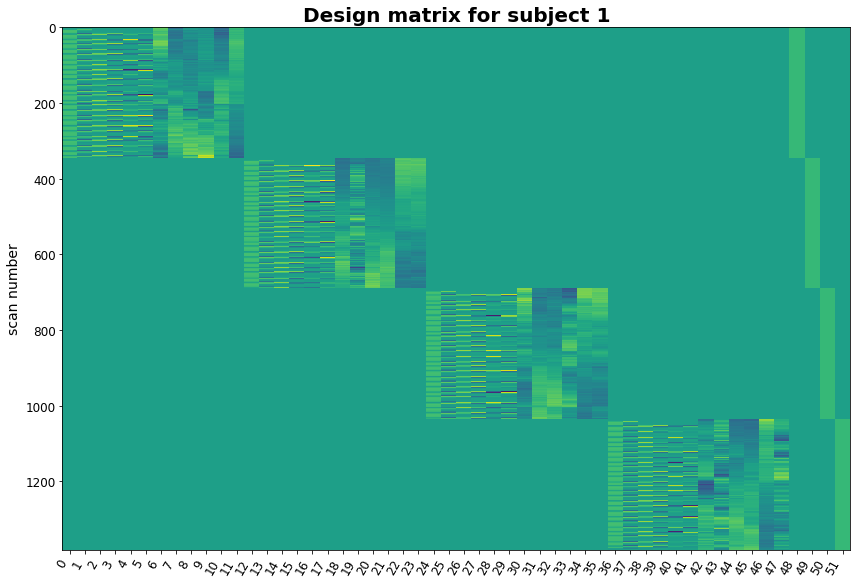

In [37]:
# Plot the design matrix 
from nistats.reporting import plot_design_matrix
fig, (ax1) = plt.subplots(figsize=(12, 8))
plot_design_matrix(design_matrix, ax = ax1)
ax1.set_title(f'Design matrix for subject {k_subject}', fontsize=20, fontweight='bold')
plt.ylabel('scan number',fontsize=14)
rc('xtick', labelsize=12)     
rc('ytick', labelsize=12)
plt.savefig('design_matrix.jpg', dpi=300)
plt.show()

In [40]:
from nistats.first_level_model import FirstLevelModel

# Specify a mask that will be used on normalised brain (MNI) only, to fasten the computations
mask_ICV = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/spm12/tpm/mask_ICV.nii'
outdir = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/ENCODAGE/tmp'

start = time.time() # starting time of the fitting procedure

## GLM
fmri_glm = FirstLevelModel(t_r=2, hrf_model=None, mask = mask_ICV, 
                           n_jobs=4, memory=outdir) 
# by default: noise_model='ar1', drift_model='cosine', period_cut=128
# hrf is 'None' because the design matrix used as input is already convolved
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrices)

end = time.time() # ending time of the fitting procedure
print('Fitting done in '+str(end-start)+' seconds!')

________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fd861960908>, <nibabel.nifti1.Nifti1Image object at 0x7fd8619d76d8>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': False,
  't_r': 2,
  'target_affine': None,
  'target_shape': None}, memory_level=1, memory=Memory(cachedir='/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/ENCODAGE/tmp/joblib'), verbose=0, confounds=None, copy=True, dtype=None)


/home/tb258044/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


________________________________________________filter_and_mask - 311.4s, 5.2min
________________________________________________________________________________
[Memory] Calling nistats.first_level_model.run_glm...
run_glm(array([[  1.017952, ...,   9.570336],
       ...,
       [ -1.164359, ..., -14.235085]], dtype=float32), 
array([[0.      , ..., 0.      ],
       ...,
       [0.577206, ..., 0.      ]]), noise_model='ar1', bins=100, n_jobs=4)
_________________________________________________________run_glm - 84.4s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fd861960da0>, <nibabel.nifti1.Nifti1Image object at 0x7fd8619d76d8>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': False,
  't_r': 2,
  'target_

/home/tb258044/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


________________________________________________filter_and_mask - 310.3s, 5.2min
________________________________________________________________________________
[Memory] Calling nistats.first_level_model.run_glm...
run_glm(array([[-5.515516, ...,  3.424418],
       ...,
       [ 3.590572, ...,  9.855843]], dtype=float32), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), noise_model='ar1', bins=100, n_jobs=4)
_________________________________________________________run_glm - 87.1s, 1.5min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fd861962b70>, <nibabel.nifti1.Nifti1Image object at 0x7fd8619d76d8>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': False,
  't_r': 2,
  'target_affine': None,
  'target_sha

/home/tb258044/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


________________________________________________filter_and_mask - 316.1s, 5.3min
________________________________________________________________________________
[Memory] Calling nistats.first_level_model.run_glm...
run_glm(array([[  1.223123, ...,  19.298862],
       ...,
       [  3.873456, ..., -30.250364]], dtype=float32), 
array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), noise_model='ar1', bins=100, n_jobs=4)
_________________________________________________________run_glm - 81.7s, 1.4min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_masker.filter_and_mask...
filter_and_mask(<nibabel.nifti1.Nifti1Image object at 0x7fd7e23385c0>, <nibabel.nifti1.Nifti1Image object at 0x7fd8619d76d8>, { 'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'sample_mask': None,
  'sessions': None,
  'smoothing_fwhm': None,
  'standardize': False,
  't_r': 2,
  'target_affine': None,
  'target

/home/tb258044/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:510: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


________________________________________________filter_and_mask - 314.3s, 5.2min
________________________________________________________________________________
[Memory] Calling nistats.first_level_model.run_glm...
run_glm(array([[ -2.174389, ...,  -6.067169],
       ...,
       [ -0.310218, ..., -11.819458]], dtype=float32), 
array([[0., ..., 1.],
       ...,
       [0., ..., 1.]]), noise_model='ar1', bins=100, n_jobs=4)
________________________________________________________run_glm - 101.2s, 1.7min
Fitting done in 1659.8640632629395 seconds!


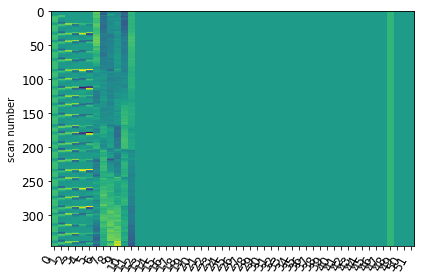

In [96]:
design_matrix_glm = fmri_glm.design_matrices_[0] # get the design matrix of the first session
from nistats.reporting import plot_design_matrix
plot_design_matrix(design_matrix_glm)
plt.show()

In [104]:
## Load the contrasts
contrast_path = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/MRI_data/analyzed_data/subj01/MultiCond/Model1_QualityCheck_contrast.mat'
contrasts_file = sio.loadmat(contrast_path)
#print(sorted(list(contrasts_file.keys())))

contrasts_names = contrasts_file['names']
contrasts_values = contrasts_file['values'][0]
#print(f'Contrasts values :{contrasts_values}')

In [43]:
# Specify the contrasts

contrasts = {'audio_minus_visual': contrasts_values[0][0],
             'visual_minus_audio': contrasts_values[1][0],
             'motor_response_onset': contrasts_values[2][0],
             'motor_response_onset_conf': contrasts_values[3][0],
             'motor_response_onset_uncertainty': contrasts_values[4][0]}
print(contrasts)

{'audio_minus_visual': array([-0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.25,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]), 'visual_minus_audio': array([ 0.25, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.25, -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,  0.25, -0.  , -0.  ,
       -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.25, -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,
       -0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ]), 'motor_response_onset': array([0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.25, 0.  , 0.  ,

/home/tb258044/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


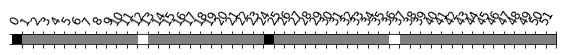

In [64]:
from nistats.reporting import plot_contrast_matrix
plot_contrast_matrix(contrasts['audio_minus_visual'], design_matrix=design_matrix)

In [44]:
### Compute and plot statistics
print('Computing contrasts...')
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('   Contrasts %2i out of %i: %s' %(
    index + 1, len(contrasts), contrast_id))
    # estimate the contrasts
    # note that the model implicitly computes a fixed effect across sessions
    z_map = fmri_glm.compute_contrast(
        contrast_val, output_type='z_score')
    
    # write the resulting stat image to file 
    z_image_path = path.join(write_dir, '%s_z_map.nii.gz' %contrast_id)
    z_map.to_filename(z_image_path)
    print('done!')

Computing contrasts...
   Contrasts  1 out of 5: audio_minus_visual


/home/tb258044/.local/lib/python3.7/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-0.687198, ...,  0.631792]), <nibabel.nifti1.Nifti1Image object at 0x7fd8619d76d8>)
___________________________________________________________unmask - 0.5s, 0.0min
done!
   Contrasts  2 out of 5: visual_minus_audio
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.687198, ..., -0.631792]), <nibabel.nifti1.Nifti1Image object at 0x7fd8619d76d8>)
___________________________________________________________unmask - 0.4s, 0.0min
done!
   Contrasts  3 out of 5: motor_response_onset
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([-1.255268, ..., -0.212829]), <nibabel.nifti1.Nifti1Image object at 0x7fd8619d76d8>)
___________________________________________________________unmask - 

/home/tb258044/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


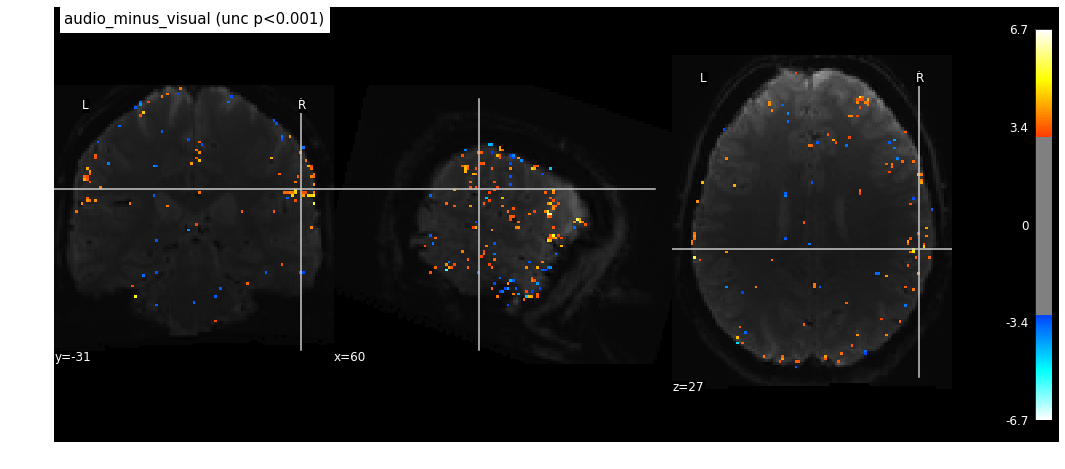

In [102]:
# Plot the first contrast = audio minus visual
contrast1 = './results/audio_minus_visual_z_map.nii.gz'
fig, (ax1) = plt.subplots(figsize=(18, 8))
plotting.plot_stat_map(
    contrast1, bg_img=mean_img_, threshold=3.1, #uncorrected p<0.001
    cut_coords = (60,-31,27.5),
    title ='audio_minus_visual (unc p<0.001)', axes=ax1)
plt.savefig('results/stat_maps/audio_minus_visual.png',dpi=300)
plt.show()

/home/tb258044/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


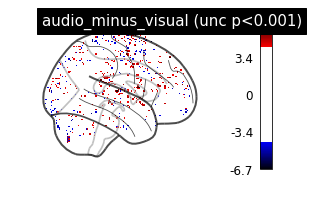

In [101]:
plotting.plot_glass_brain(contrast1, colorbar=True, threshold=4.3,
                          title='audio_minus_visual (unc p<0.001)',
                          plot_abs=False, display_mode='x')
plotting.show()

/home/tb258044/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


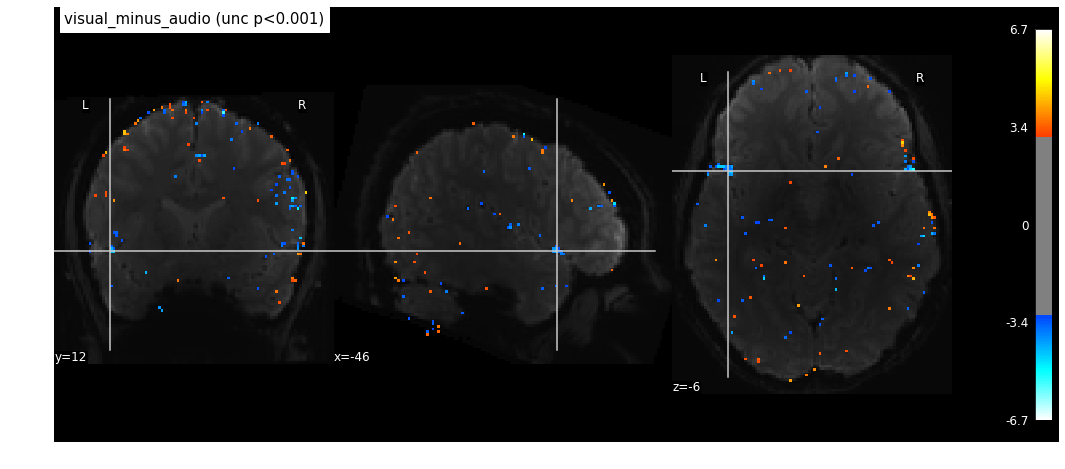

In [83]:
# Plot the first contrast = audio minus visual
contrast2 = './results/visual_minus_audio_z_map.nii.gz'
fig, (ax1) = plt.subplots(figsize=(18,8))
plotting.plot_stat_map(
    contrast2, bg_img=mean_img_, threshold=3.1, # uncorrected p<0.001
    title ='visual_minus_audio (unc p<0.001)', axes=ax1)
plt.savefig('results/stat_maps/visual_minus_audio.png', dpi=300)
plt.show()